# House Price Prediction - Advanced Regression Techniques

## Table of Contents
- [Data collection & initial exploration](#Data-collection-&-initial-exploration)
  - [Setup and imports](#setup-and-imports)
  - [Initial exploration](#initial-exploration)
- [Feature engineering](#feature-engineering)
  - [Preprocessing](#preprocessing)
    - [Data Cleaning](#Data-cleaning)
      - [Identify columns with missing values](#identify-columns-with-missing-values)
      - [Drop columns](#drop-columns)
      - [Impute missing values](#impute-missing-values)
  - [Concatenation](#Concatenation)
  - [Encoding](#Encoding)
  - [Split](#split)
- [Model Building](#Model-Building)
  - [Model 1 - Linear regression](#Model-1---Linear-regression)
    - [First try linear regression & performance](#first-try-linear-regression-&-performance)
    - [Enhancement of linear regression](#enhancement-of-linear-regression)
  - [Model 2 - Random forest](#Model-2---Random-forest)
    - [First try random forest & performance](#first-try-random-forest-&-performance)
    - [Enhancement of random forest](#enhancement-of-random-forest)
  - [Model 3 - XGBoost](#Model-3---XGBoost)
    - [First try XGBoost & performance](#first-try-xgboost-&-performance)
    - [Enhancement of XGBoost](#enhancement-of-xgboost)
- [Conclusion & submission](#conclusion-&-submission)



# Data collection & initial exploration

## Setup and imports

In [1069]:
#Import relevant packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder

In [1070]:
#Read in training data 
train_df = pd.read_csv('train.csv')
#Read in test data
test_df = pd.read_csv('test.csv')
# set seed for reproducibility
np.random.seed(0)

#Delete ID columns
train_df.drop(['Id'], axis=1, inplace=True)
test_df.drop(['Id'], axis=1, inplace=True)

We drop the ID column to make sure this feature does not affect the prediction. 

## Exploratory Data Analysis (EDA)

In [1071]:
#Show first five rows of dataframe. This gives us an initial overview over what we are dealing with. 
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1072]:
train_df.shape

(1460, 80)

In [1073]:
train_df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

Initial exploration shows us that the training dataset consists of 1460 rows, and 80 columns. The final column includes the target feature: sale price. The dataset contains various datatypes like int64, float64 and object. We will handle this later under "encoding". 

In [1074]:
# find categorical variables
categorical = [var for var in train_df.columns if train_df[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 43 categorical variables


In [1075]:
# find numerical variables
numerical = [var for var in train_df.columns if train_df[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 37 numerical variables


We  will assume that variables with a definite and low number of unique values are discrete.

In [1076]:
# Visualizing the values of the discrete variables
discrete = []
for var in numerical:
    if len(train_df[var].unique())<20:
        print(var, ' values: ', train_df[var].unique())
        discrete.append(var)

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold  values:  [2008 2007 2006 2009 2010]


In [1077]:
# first we make a list of continuous variables (from the numerical ones)
continuous = [var for var in numerical if var not in discrete and var not in ['SalePrice']]
continuous

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

### HeatMap

We use a correlation matrix to see what is most important for the house price

/var/folders/vk/b9g86spn6n9d9mny96n4mww80000gn/T/ipykernel_30822/3047300281.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train_df.corr()


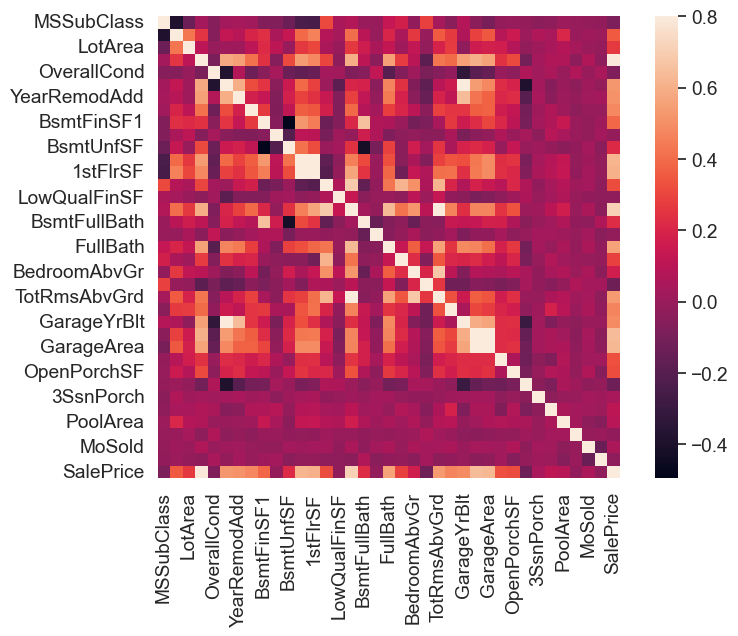

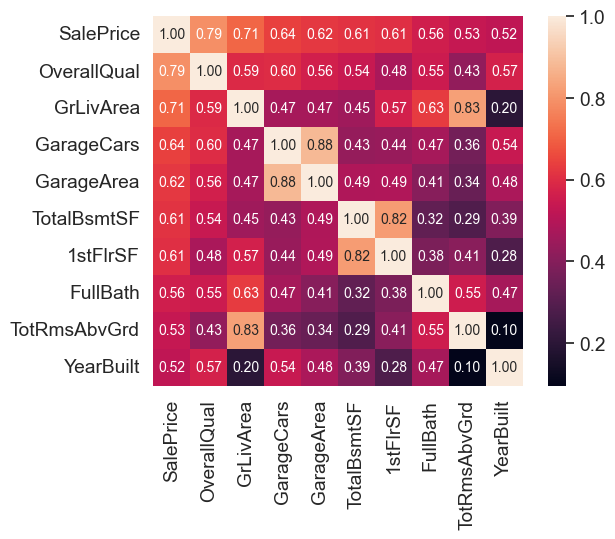

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


In [1078]:
# Correlation Matrix Heatmap
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

# Top 10 Heatmap
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

# Feature engineering

## Preprocessing

### Skew in SalePrice

/var/folders/vk/b9g86spn6n9d9mny96n4mww80000gn/T/ipykernel_30822/1686454584.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'] , fit=norm);



 mu = 180921.20 and sigma = 79415.29



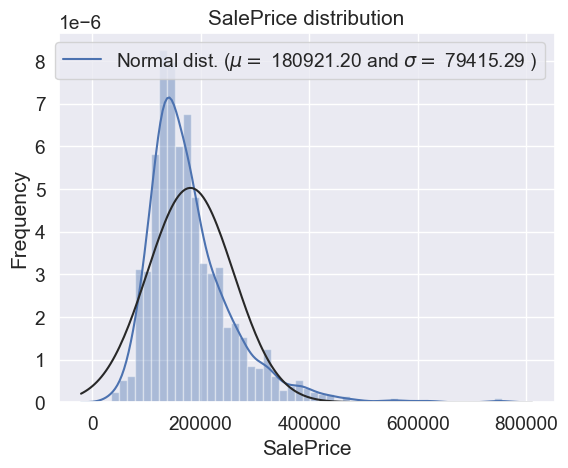

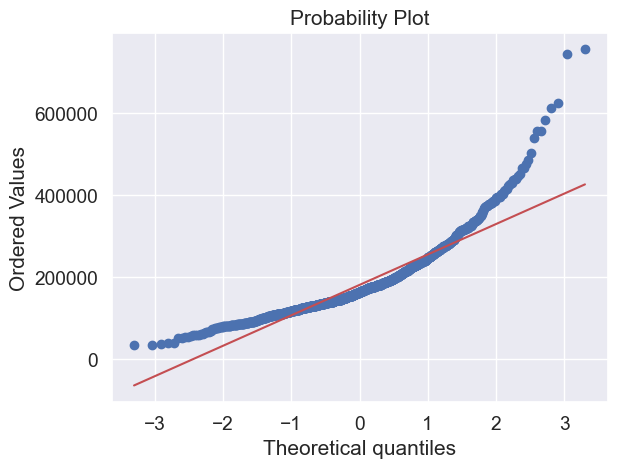

/var/folders/vk/b9g86spn6n9d9mny96n4mww80000gn/T/ipykernel_30822/1686454584.py:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'] , fit=norm)



 mu = 12.02 and sigma = 0.40



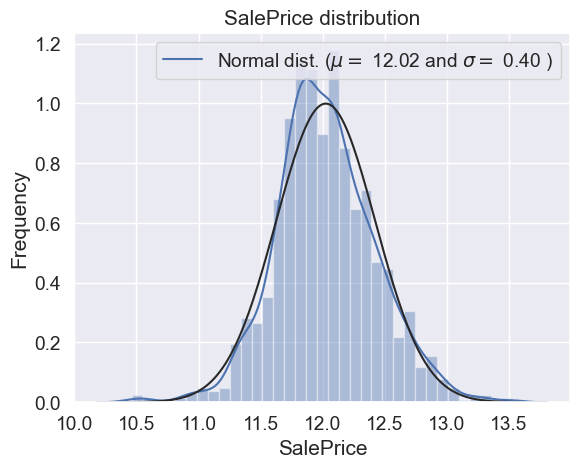

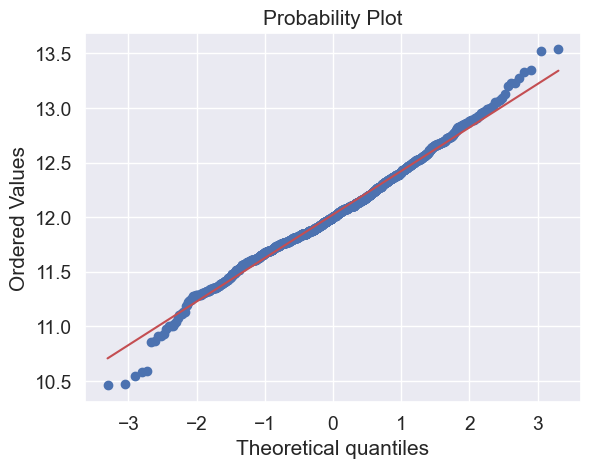

In [1079]:


from scipy import stats
from scipy.stats import norm, skew #for some statistics

sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

#We use the numpy fuction log1p
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

#Check the new distribution 
sns.distplot(train_df['SalePrice'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Plot the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

### Handling outliers

#### Outliers in continous variables

(1460, 80)
(1192, 80)


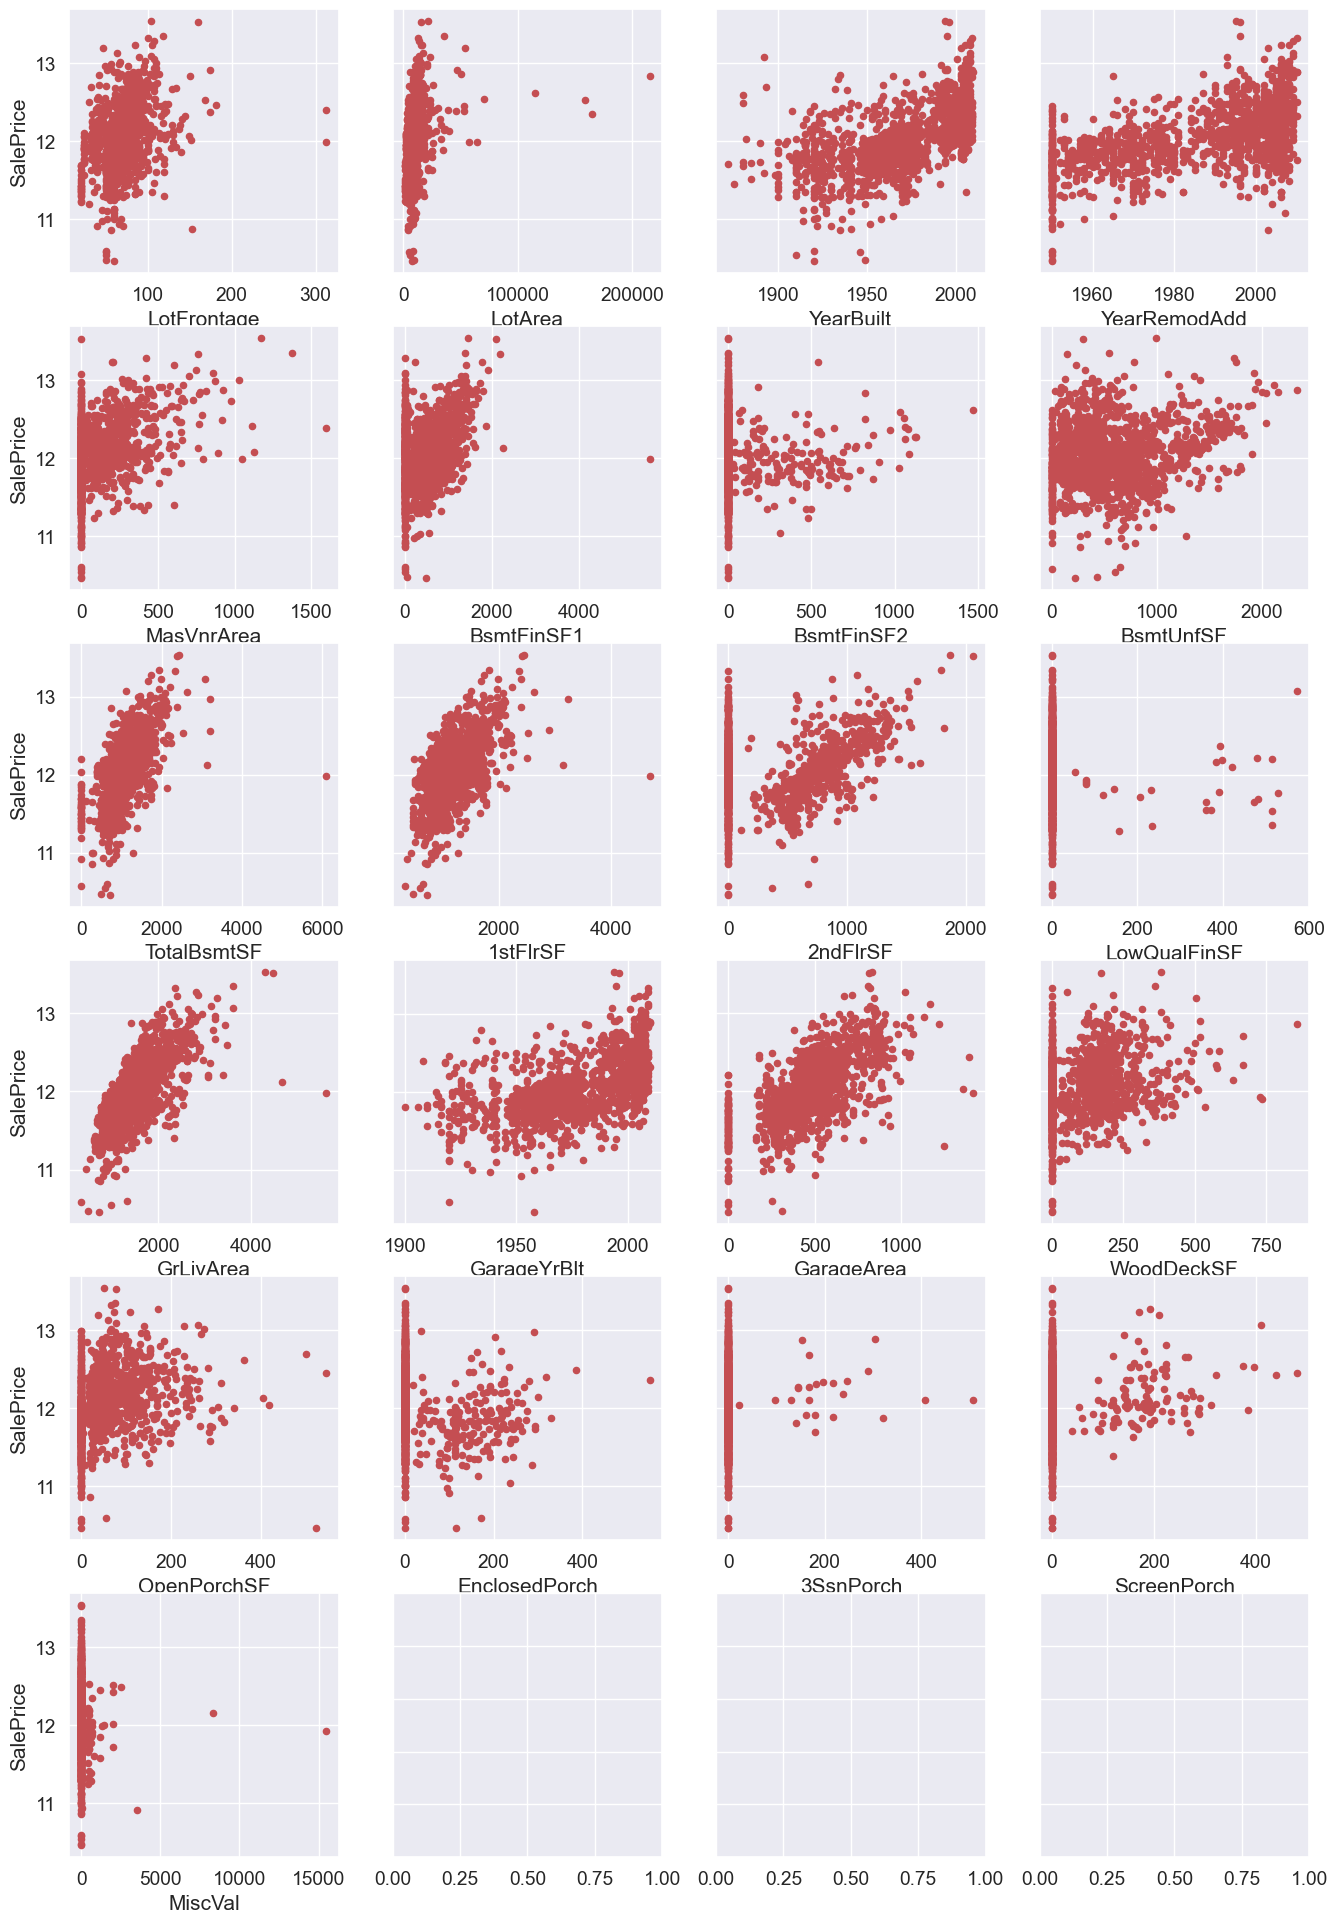

In [1080]:
fig, axes = plt.subplots(6, 4, figsize=(16, 24))

for i, c in enumerate(continuous):
    row = i // 4
    col = i % 4
    train_df.plot.scatter(ax=axes[row, col], x=c, y='SalePrice', sharey=True, colorbar=False, c='r')

print(train_df.shape)
train_df = train_df[train_df['GrLivArea'] < 4500]
train_df = train_df[train_df['LotArea'] < 100000]
train_df = train_df[train_df['TotalBsmtSF'] < 3000]
train_df = train_df[train_df['1stFlrSF'] < 2500]
train_df = train_df[train_df['BsmtFinSF1'] < 2000]
train_df = train_df[train_df['LotArea'] < 100000]
train_df = train_df[train_df['LotFrontage'] < 200]
train_df = train_df[train_df['BsmtFinSF1'] < 5000]
print(train_df.shape)


#### Outliers in discrete variables

In [1081]:
for var in discrete:
    value_counts = train_df[var].value_counts() / len(train_df)
    categories_to_remove = value_counts[value_counts < 0.01].index
    train_df = train_df[~train_df[var].isin(categories_to_remove)] 

In [1082]:
train_df.shape

(1121, 80)

### Concatenation

In [1083]:
train_test_df = pd.concat([train_df,test_df],axis=0)

### New features

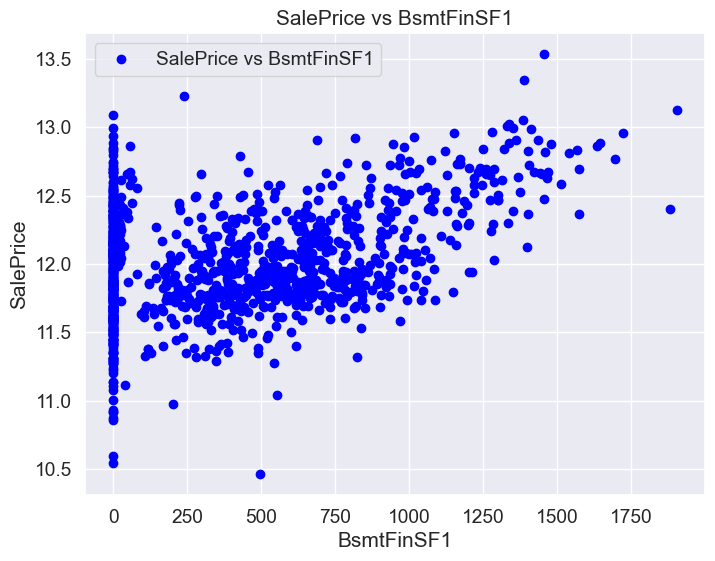

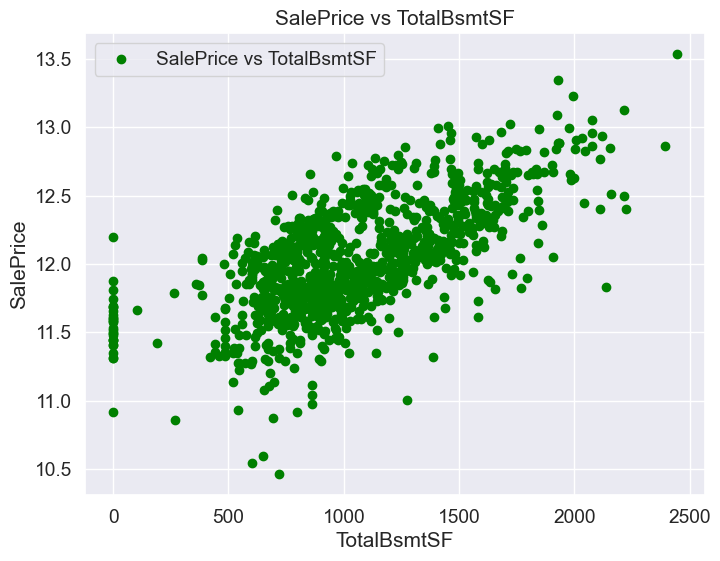

In [1084]:
train_test_df['TotalIndoorArea']  = train_test_df['1stFlrSF'] + train_test_df['2ndFlrSF'] + train_test_df['TotalBsmtSF'] + train_test_df['GrLivArea']

import matplotlib.pyplot as plt

# Plotting 'SalePrice' vs 'BsmtFinSF1'
plt.figure(figsize=(8, 6))
plt.scatter(train_test_df['BsmtFinSF1'], train_test_df['SalePrice'], color='blue', label='SalePrice vs BsmtFinSF1')
plt.xlabel('BsmtFinSF1')
plt.ylabel('SalePrice')
plt.title('SalePrice vs BsmtFinSF1')
plt.legend()
plt.show()

# Plotting 'SalePrice' vs 'TotalBsmtSF'
plt.figure(figsize=(8, 6))
plt.scatter(train_test_df['TotalBsmtSF'], train_test_df['SalePrice'], color='green', label='SalePrice vs TotalBsmtSF')
plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePrice')
plt.title('SalePrice vs TotalBsmtSF')
plt.legend()
plt.show()

train_test_df["Square_BsmtFinSF1"] = train_test_df["BsmtFinSF1"] ** 2
train_test_df["Square_TotalBsmtSF"] = train_test_df["TotalBsmtSF"] ** 2


###  Replace NA with None for features where NA means that the house does not have it

In [1085]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 
            'BsmtFinType1', 'BsmtFinType2',
            'GarageType', 'GarageFinish', 'GarageQual', 
            'GarageCond'):
    train_test_df[col] = train_test_df[col].fillna('None')

### Data cleaning

#### Identify columns with missing values
The first cleaning of data we are going to do is handle columns with missing data points.

MSZoning                 4
LotFrontage            227
Alley                 2392
Utilities                2
Exterior1st              1
Exterior2nd              1
MasVnrType              22
MasVnrArea              21
BsmtFinSF1               1
BsmtFinSF2               1
BsmtUnfSF                1
TotalBsmtSF              1
Electrical               1
BsmtFullBath             2
BsmtHalfBath             2
KitchenQual              1
Functional               2
FireplaceQu           1287
GarageYrBlt            132
GarageCars               1
GarageArea               1
PoolQC                2577
Fence                 2079
MiscFeature           2495
SaleType                 1
SalePrice             1459
TotalIndoorArea          1
Square_BsmtFinSF1        1
Square_TotalBsmtSF       1
dtype: int64


Text(0.5, 1.0, 'Percent missing data by feature')

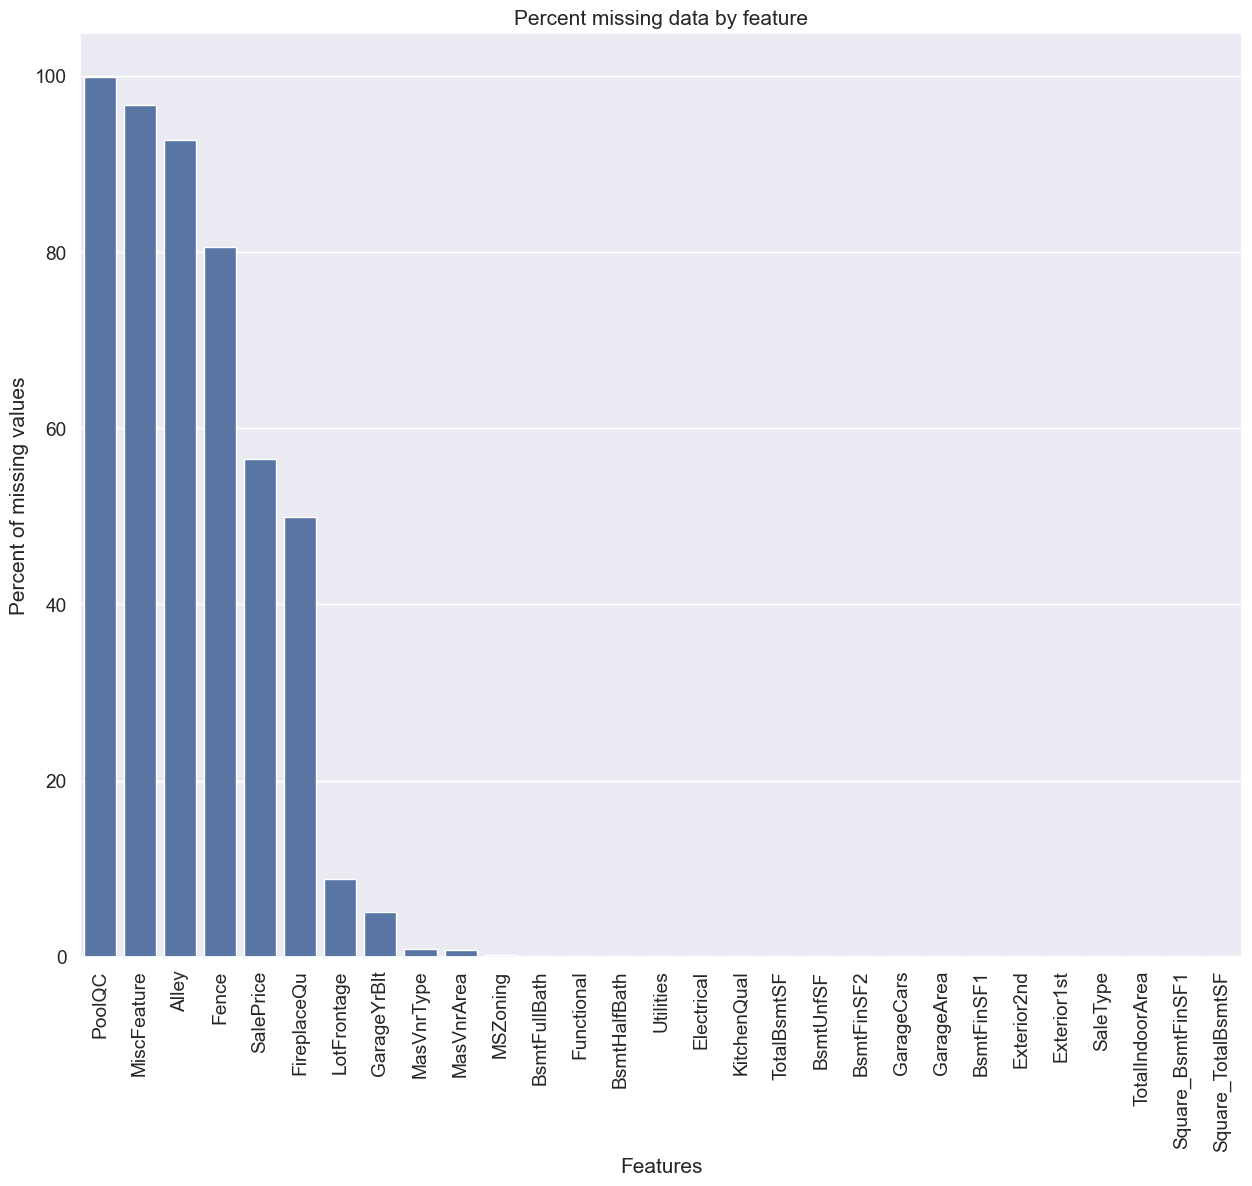

In [1086]:
#Get the number of missing data points per column
missing_values_count = train_test_df.isnull().sum()
#Get columns with at least one missing data point
columns_with_missing_data = missing_values_count[missing_values_count > 0]

print(columns_with_missing_data)


all_data_na = (train_test_df.isnull().sum() / len(train_test_df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

#### Feature Selection
We will drop columns which are missing more than 80% of their values.
<font color='red'>Should find a source which recommends percentage of missingness to drop a column.</font> 

In [1087]:
#Create list of columns which miss more values than 80%.
columns_to_drop = missing_values_count[missing_values_count > 0.8*len(train_test_df)].index
print(columns_to_drop)
train_test_df.drop(columns=columns_to_drop, inplace=True)
train_test_df.shape

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')


(2580, 79)

Can now see that the four columns "Alley", "PoolQC", "Fence" and "MiscFeature" have been removed. 

#### Impute missing values
For the rest of the columns with missing values we will impute values. For the numeric columns we will impute the mean of the values in the column, and for the categorical columns we will impute the mode. 

In [1088]:
train_test_df['LotFrontage'] = train_test_df['LotFrontage'].fillna(train_test_df['LotFrontage'].mean())
train_test_df['MasVnrArea'] = train_test_df['MasVnrArea'].fillna(train_test_df['MasVnrArea'].mean())
train_test_df['GarageYrBlt'] = train_test_df['GarageYrBlt'].fillna(train_test_df['GarageYrBlt'].mean())
train_test_df['MasVnrType'] = train_test_df['MasVnrType'].fillna(train_test_df['MasVnrType'].mode()[0])
train_test_df['BsmtQual'] = train_test_df['BsmtQual'].fillna(train_test_df['BsmtQual'].mode()[0])
train_test_df['BsmtCond'] = train_test_df['BsmtCond'].fillna(train_test_df['BsmtCond'].mode()[0])
train_test_df['BsmtExposure'] = train_test_df['BsmtExposure'].fillna(train_test_df['BsmtExposure'].mode()[0])
train_test_df['BsmtFinType1'] = train_test_df['BsmtFinType1'].fillna(train_test_df['BsmtFinType1'].mode()[0])
train_test_df['BsmtFinType2'] = train_test_df['BsmtFinType2'].fillna(train_test_df['BsmtFinType2'].mode()[0])
train_test_df['Electrical'] = train_test_df['Electrical'].fillna(train_test_df['Electrical'].mode()[0])
train_test_df['FireplaceQu'] = train_test_df['FireplaceQu'].fillna(train_test_df['FireplaceQu'].mode()[0])
train_test_df['GarageType'] = train_test_df['GarageType'].fillna(train_test_df['GarageType'].mode()[0])
train_test_df['GarageFinish'] = train_test_df['GarageFinish'].fillna(train_test_df['GarageFinish'].mode()[0])
train_test_df['GarageQual'] = train_test_df['GarageQual'].fillna(train_test_df['GarageQual'].mode()[0])
train_test_df['GarageCond'] = train_test_df['GarageCond'].fillna(train_test_df['GarageCond'].mode()[0])
train_test_df['MSZoning']=train_test_df['MSZoning'].fillna(train_test_df['MSZoning'].mode()[0])
train_test_df['Utilities']=train_test_df['Utilities'].fillna(train_test_df['Utilities'].mode()[0])
train_test_df['Exterior1st']=train_test_df['Exterior1st'].fillna(train_test_df['Exterior1st'].mode()[0])
train_test_df['Exterior2nd']=train_test_df['Exterior2nd'].fillna(train_test_df['Exterior2nd'].mode()[0])
train_test_df['MasVnrArea']=train_test_df['MasVnrArea'].fillna(train_test_df['MasVnrArea'].mode()[0])
train_test_df['BsmtFinSF1']=train_test_df['BsmtFinSF1'].fillna(train_test_df['BsmtFinSF1'].mean())
train_test_df['BsmtFinSF2']=train_test_df['BsmtFinSF2'].fillna(train_test_df['BsmtFinSF2'].mean())
train_test_df['BsmtUnfSF']=train_test_df['BsmtUnfSF'].fillna(train_test_df['BsmtUnfSF'].mean())
train_test_df['TotalBsmtSF']=train_test_df['TotalBsmtSF'].fillna(train_test_df['TotalBsmtSF'].mean())
train_test_df['BsmtFullBath']=train_test_df['BsmtFullBath'].fillna(train_test_df['BsmtFullBath'].mode()[0])
train_test_df['BsmtHalfBath']=train_test_df['BsmtHalfBath'].fillna(train_test_df['BsmtHalfBath'].mode()[0])
train_test_df['KitchenQual']=train_test_df['KitchenQual'].fillna(train_test_df['KitchenQual'].mode()[0])
train_test_df['Functional']=train_test_df['Functional'].fillna(train_test_df['Functional'].mode()[0])
train_test_df['GarageYrBlt']=train_test_df['GarageYrBlt'].fillna(train_test_df['GarageYrBlt'].mean())
train_test_df['GarageCars']=train_test_df['GarageCars'].fillna(train_test_df['GarageCars'].mean())
train_test_df['GarageArea']=train_test_df['GarageArea'].fillna(train_test_df['GarageArea'].mean())
train_test_df['SaleType']=train_test_df['SaleType'].fillna(train_test_df['SaleType'].mode()[0])
train_test_df['TotalIndoorArea']=train_test_df['TotalIndoorArea'].fillna(train_test_df['TotalIndoorArea'].mean())
train_test_df['Square_BsmtFinSF1']=train_test_df['Square_BsmtFinSF1'].fillna(train_test_df['Square_BsmtFinSF1'].mean())
train_test_df['Square_TotalBsmtSF']=train_test_df['Square_TotalBsmtSF'].fillna(train_test_df['Square_TotalBsmtSF'].mean())



# Check that we have no missing datapoints.
missing_values_count = train_test_df.isnull().sum()
columns_with_missing_data = missing_values_count[missing_values_count > 0]
print(columns_with_missing_data)

SalePrice    1459
dtype: int64


Sale price will still miss 1459 values, which are the sale-price of our test set. We ignore that there are missing values here, as it is correct because this is the value we are going to predict.

### Fixing Skewed Features

In [1089]:
from operator import itemgetter
def find_skewness(train, numeric_cols):
    """
    Calculate the skewness of the columns and segregate the positive
    and negative skewed data.
    """
    skew_dict = {}
    for col in numeric_cols:
        skew_dict[col] = train[col].skew()

    skew_dict = dict(sorted(skew_dict.items(),key=itemgetter(1)))
    positive_skew_dict = {k:v for (k,v) in skew_dict.items() if v>0}
    negative_skew_dict = {k:v for (k,v) in skew_dict.items() if v<0}
    return skew_dict, positive_skew_dict, negative_skew_dict

def add_constant(data, highly_pos_skewed):
    """
    Look for zeros in the columns. If zeros are present then the log(0) would result in -infinity.
    So before transforming it we need to add it with some constant.
    """
    C = 1
    for col in highly_pos_skewed.keys():
        if(col != 'SalePrice'):
            if(len(data[data[col] == 0]) > 0):
                data[col] = data[col] + C
    return data

def log_transform(data, highly_pos_skewed):
    """
    Log transformation of highly positively skewed columns.
    """
    for col in highly_pos_skewed.keys():
        if(col != 'SalePrice'):
            data[col] = np.log10(data[col])
    return data

def sqrt_transform(data, moderately_pos_skewed):
    """
    Square root transformation of moderately skewed columns.
    """
    for col in moderately_pos_skewed.keys():
        if(col != 'SalePrice'):
            data[col] = np.sqrt(data[col])
    return data

def reflect_sqrt_transform(data, moderately_neg_skewed):
    """
    Reflection and log transformation of highly negatively skewed 
    columns.
    """
    for col in moderately_neg_skewed.keys():
        if(col != 'SalePrice'):
            K = max(data[col]) + 1
            data[col] = np.sqrt(K - data[col])
    return data


"""
If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.
"""
skew_dict, positive_skew_dict, negative_skew_dict = find_skewness(train_test_df, numerical)
moderately_pos_skewed = {k:v for (k,v) in positive_skew_dict.items() if v>0.5 and v<=1}
highly_pos_skewed = {k:v for (k,v) in positive_skew_dict.items() if v>1}
moderately_neg_skewed = {k:v for (k,v) in negative_skew_dict.items() if v>-1 and v<=0.5}
highly_neg_skewed = {k:v for (k,v) in negative_skew_dict.items() if v<-1}

'''Transform train data.'''
train_test_df  = add_constant(train_test_df , highly_pos_skewed)
train_test_df  = log_transform(train_test_df , highly_pos_skewed)
train_test_df  = sqrt_transform(train_test_df , moderately_pos_skewed)
train_test_df  = reflect_sqrt_transform(train_test_df , moderately_neg_skewed )


## Encoding
To use our models we have to encode the categorical columns in our dataset. To do this we will use the sklearns One hot encoder.

In [1090]:
# Identify categorical columns
categorical_columns = train_test_df.select_dtypes(include=['object']).columns

# Preprocess the data to ensure categorical columns contain only strings
train_test_df[categorical_columns] = train_test_df[categorical_columns].astype(str)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')

# Fit and transform the categorical data using one-hot encoding
X_encoded = encoder.fit_transform(train_test_df[categorical_columns])

# Get the feature names
feature_names = encoder.get_feature_names_out(input_features=categorical_columns)

# Create a DataFrame with the one-hot encoded features
X_encoded_train_test_df = pd.DataFrame(X_encoded, columns=feature_names)

# Reset the index of both DataFrames
X_encoded_train_test_df.reset_index(drop=True, inplace=True)
train_test_df.reset_index(drop=True, inplace=True)

# Combine the one-hot encoded features with the original numerical features
train_test_df = pd.concat([X_encoded_train_test_df, train_test_df.drop(categorical_columns, axis=1)], axis=1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Split
Now we will split the train and test set so we can train a regression model, and then use this model to predict the test-data.

In [1091]:
# nan_mask = train_df['SalePrice'].isna()
nan_mask = train_test_df['SalePrice'].isna()

# Use diff() to find the transition from non-NaN to NaN
transition_mask = nan_mask.diff() == True

# Find the index of the first occurrence of the transition
border_index = transition_mask.idxmax()

print(border_index)

HPP_data_Train = train_test_df.iloc[:border_index,:]
HPP_data_Test = train_test_df.iloc[border_index:,:]

#Dropping SalePrice in test-data. This is the value we are going to predict.
HPP_data_Test.drop(['SalePrice'],axis=1,inplace=True)

1121


/var/folders/vk/b9g86spn6n9d9mny96n4mww80000gn/T/ipykernel_30822/3938602792.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HPP_data_Test.drop(['SalePrice'],axis=1,inplace=True)


# Model building

## Model 1 - Linear regression

### Linear regression & performance

0.12106009857901787


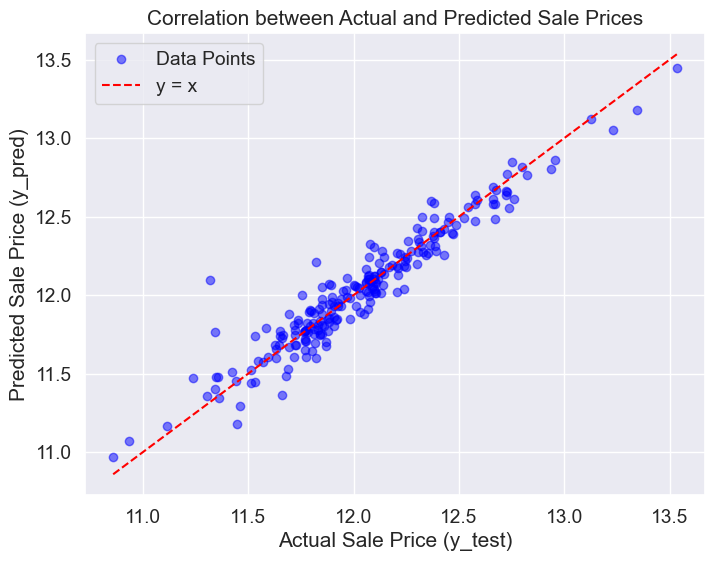

In [1092]:
# Import the necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# X_train contains features, and y_train contains the target variable (SalePrice).
X_train= HPP_data_Train.drop(['SalePrice'],axis=1)
y_train= HPP_data_Train['SalePrice']

#Initialize the linear regression model
linear_regression_model = LinearRegression()

#Cross Validation
k_folds = 5
kf = KFold(k_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
rmse= np.sqrt(-cross_val_score(linear_regression_model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
print(rmse.mean())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit the liner_regression_model to the training data
linear_regression_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = linear_regression_model.predict(X_test)

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.5, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='y = x')
plt.xlabel("Actual Sale Price (y_test)")
plt.ylabel("Predicted Sale Price (y_pred)")
plt.title("Correlation between Actual and Predicted Sale Prices")
plt.legend()
plt.show()

### Submission of LR predictions

In [1093]:
# X_train contains features, and y_train contains the target variable (SalePrice).
X_train= HPP_data_Train.drop(['SalePrice'],axis=1)
y_train= HPP_data_Train['SalePrice']

linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)
# Make predictions on the test data
y_pred = linear_regression_model.predict(HPP_data_Test)

# Apply np.expm1 to the y_pred values
y_pred_expm1 = np.expm1(y_pred)

pred_LR=pd.DataFrame(y_pred_expm1)
# Create a DataFrame with 'Id' values (1461 to N+1460) and the 'SalePrice' values from 'pred'
pred_LR['Id'] = range(1461, 1461 + len(pred_LR))
pred_LR = pred_LR.rename(columns={0: 'SalePrice'})
# Create a new DataFrame with columns named "Id" and "SalePrice"
result_df = pred_LR[['Id', 'SalePrice']]
# Save the DataFrame to a CSV file
result_df.to_csv('predicted_saleprice_LR.csv', index=False)

## Model 2 - Random forest

### Random forest & performance

0.13993217793674634


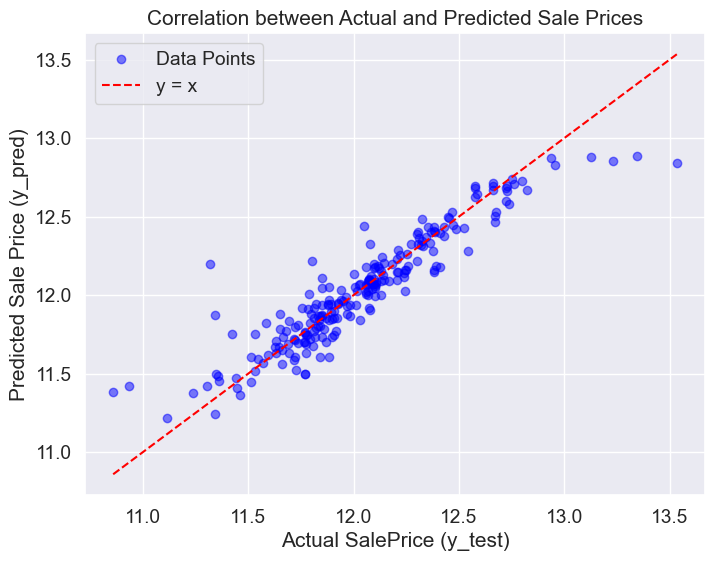

In [1094]:
# Import the necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# X_train should contain your features, and y_train should contain the target variable (SalePrice).
X_train = HPP_data_Train.drop(['SalePrice'], axis=1)
y_train = HPP_data_Train['SalePrice']

# Initialize the RandomForestRegressor model
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=11)

#Cross Validation
k_folds = 5
kf = KFold(k_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
rmse= np.sqrt(-cross_val_score(random_forest_regressor, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
print(rmse.mean())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit the model to the training data
random_forest_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = random_forest_regressor.predict(X_test)

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.5, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='y = x')
plt.xlabel("Actual SalePrice (y_test)")
plt.ylabel("Predicted Sale Price (y_pred)")
plt.title("Correlation between Actual and Predicted Sale Prices")
plt.legend()
plt.show()

### Submission of Random Forest prediction

In [1095]:
# X_train contains features, and y_train contains the target variable (SalePrice).
X_train= HPP_data_Train.drop(['SalePrice'],axis=1)
y_train= HPP_data_Train['SalePrice']

random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=11)
# Fit the model to the training data
random_forest_regressor.fit(X_train, y_train)
# Make predictions on the test data
y_pred = random_forest_regressor.predict(HPP_data_Test)
# Apply np.expm1 to the y_pred values
y_pred_expm1 = np.expm1(y_pred)

# Create a DataFrame with 'Id' values (1461 to N+1460) and the 'SalePrice' values from 'pred'
pred_RF=pd.DataFrame(y_pred_expm1)
pred_RF['Id'] = range(1461, 1461 + len(pred_RF))
pred_RF = pred_RF.rename(columns={0: 'SalePrice'})
# Create a new DataFrame with columns named "Id" and "SalePrice"
result_df = pred_RF[['Id', 'SalePrice']]
# Save the DataFrame to a CSV file
result_df.to_csv('predicted_saleprice_RF.csv', index=False)

## Model 3 -  XG boost

### Performance

0.1284095581117511


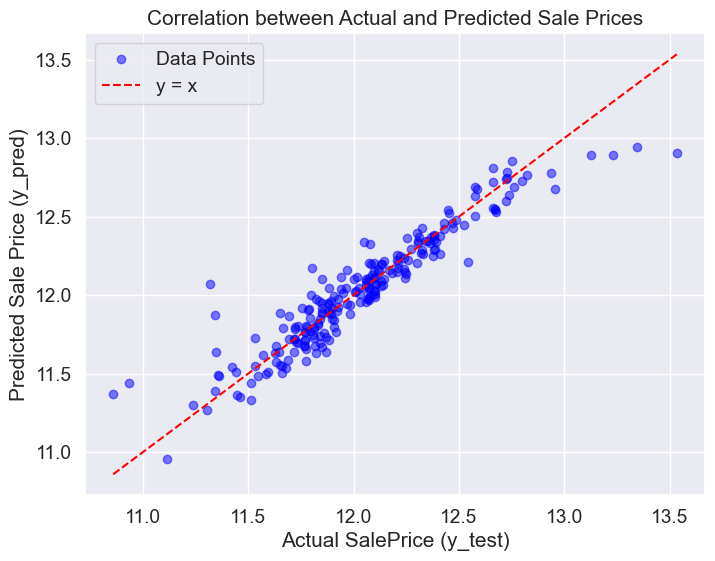

In [1096]:
# Import the necessary libraries
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# X_train should contain your features, and y_train should contain the target variable (SalePrice).
X_train = HPP_data_Train.drop(['SalePrice'], axis=1)
y_train = HPP_data_Train['SalePrice']

# Initialize the XGBoost model
xgboost_regressor = xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=2)  # You can adjust the number of estimators as needed

# Cross Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
rmse = np.sqrt(-cross_val_score(xgboost_regressor, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
print(rmse.mean())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit the model to the training data
xgboost_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgboost_regressor.predict(X_test)

# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.5, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='y = x')
plt.xlabel("Actual SalePrice (y_test)")
plt.ylabel("Predicted Sale Price (y_pred)")
plt.title("Correlation between Actual and Predicted Sale Prices")
plt.legend()
plt.show()


In [1097]:
# X_train contains features, and y_train contains the target variable (SalePrice).
X_train= HPP_data_Train.drop(['SalePrice'],axis=1)
y_train= HPP_data_Train['SalePrice']

# Initialize the XGBoost model
xgboost_regressor = xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=2)  # You can adjust the number of estimators as needed

# Fit the model to the training data
xgboost_regressor.fit(X_train, y_train)
# Make predictions on the test data
y_pred = xgboost_regressor.predict(HPP_data_Test)
# Apply np.expm1 to the y_pred values
y_pred_expm1 = np.expm1(y_pred)

# Create a DataFrame with 'Id' values (1461 to N+1460) and the 'SalePrice' values from 'pred'
pred_XGB=pd.DataFrame(y_pred_expm1)
pred_XGB['Id'] = range(1461, 1461 + len(pred_XGB))
pred_XGB = pred_XGB.rename(columns={0: 'SalePrice'})
# Create a new DataFrame with columns named "Id" and "SalePrice"
result_df = pred_XGB[['Id', 'SalePrice']]
# Save the DataFrame to a CSV file
result_df.to_csv('predicted_saleprice_XGB.csv', index=False)

# Conclusion & submission

In [1098]:
# Our best model is PRED_RF
pred = pred_XGB
# Create a DataFrame with 'Id' values (1461 to N+1460) and the 'SalePrice' values from 'pred'
pred['Id'] = range(1461, 1461 + len(pred))
pred = pred.rename(columns={0: 'SalePrice'})
# Create a new DataFrame with columns named "Id" and "SalePrice"
result_df = pred[['Id', 'SalePrice']]
# Save the DataFrame to a CSV file
result_df.to_csv('predicted_saleprice.csv', index=False)